# Assessing DFA methods and the power spectrum analysis
The aim of this notebook is to check if the methods used for DFA and power spectrum analysis are accurate. For that, various signals with different Hurst exponents are generated. Then, the DFA methods are used on these signals. Finally, the value computed is compared with the actual exponent.

The 2 DFA methods used are:
- The one implemented for this work (available in ../FractalAnalysis.py)
- The one that is available in the MFDFA package

In a similar way, the power spectrum analysis is also assessed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import random


# Generate signals
import stochastic.processes.noise
from fbm import FBM

from statsmodels.graphics.tsaplots import plot_acf

# DFA
import sys
sys.path.append('../')
import FractalAnalysis as fa

## Generate a signal
The first thing to do is to generate a signal based on the $\alpha$ (from DFA) or $\beta$ (from spectrum analysis) value that will be expected. Most of the methods that will be used in this notebook will ask for the Hurst exponent $H$ as a parameter.
- $H = \alpha$ if the signal is a fractional Gaussian noise (i.e. $\alpha \in [0,1]$)
- $H = \alpha - 1$ if the signal is a fractional Brownian motion (i.e. $\alpha \in [1,2]$)

Note that $\beta = 2\alpha - 1$.

### FBM package
Two different packages will be uses for generating a signal. The first one is the FBM package. In this package, a method can be called to generate a signal based on a given Hurst exponent. From there, both the fractional Gaussian noise(fgn) and the fractional Brownian motion(fbm) can be generated.

However, the second package should be favoured as this one has poor results when the Hurst exponent becomes close to 0 or 1.

In [2]:
f = FBM(n=10000, hurst=0.5, length=1, method='daviesharte')

# Generate a fBm realization
fbm_sample = f.fbm()

# Generate a fGn realization
fgn_sample = f.fgn()

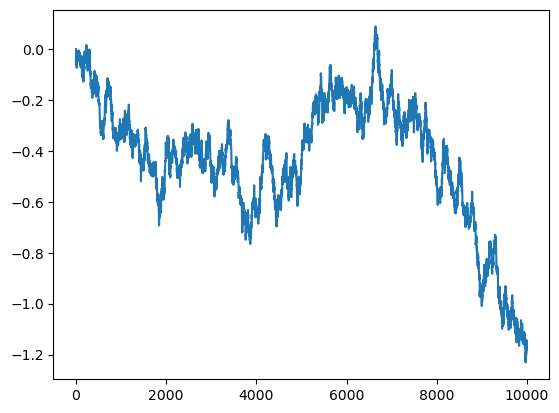

In [3]:
plt.plot(fbm_sample)
plt.show()

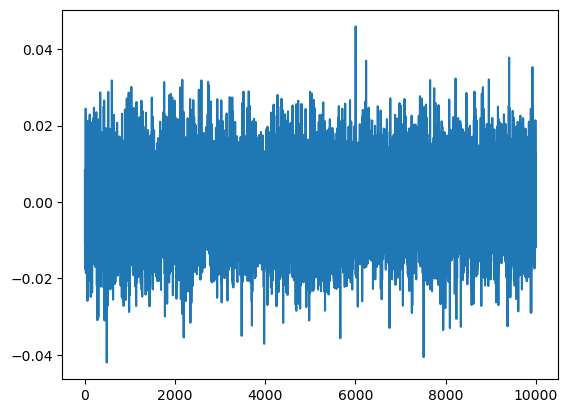

In [4]:
plt.plot(fgn_sample)
plt.show()

### Stochastic package
The second package is a package that offers various methods to generate different signals. Two of them were selected for this notebook:
- $\texttt{FractionalGaussianNoise}$ that takes as an argument the hurst exponent and generates the appropriate fgn signal
- $\texttt{ColoredNoise}$ that takes as an argument the power spectrum value $\beta$ and returns the appropriate signal

The last method is the one to be favored for the analysis as the first one will limit the test value for the DFA analysis between 0 and 1.

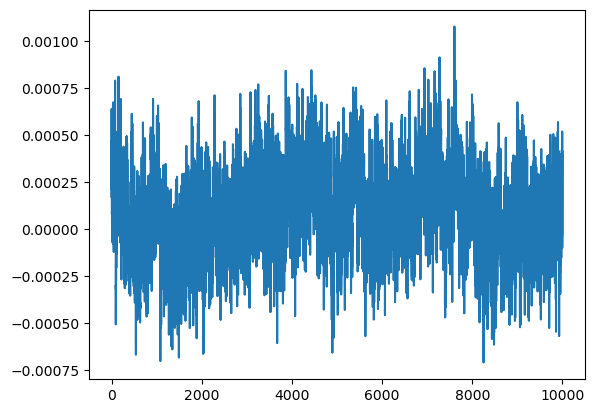

In [5]:
noise = stochastic.processes.noise.FractionalGaussianNoise(hurst=0.9)
plt.plot(noise.sample(10000))
plt.show()

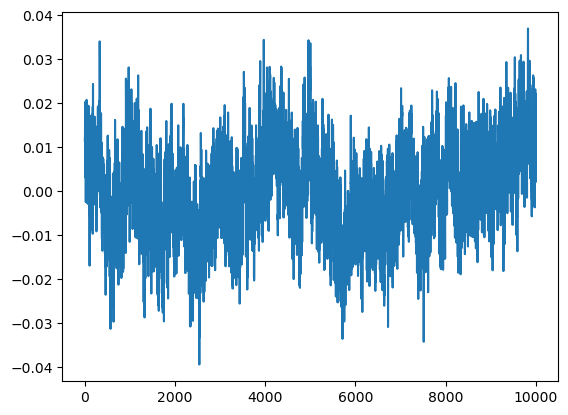

In [6]:
noise = stochastic.processes.noise.ColoredNoise(beta=1)
plt.plot(noise.sample(10000))
plt.show()

# Assessing the methods

In [10]:
def get_alphas(beats, lag, start=5, end=500, plot=False):
    """
    Method that computes the Hurst exponent with the DFA methods

    Arguments:
    - beats: the signal to analyse
    - lag: the time scale to use in the DFA (for the second method)
    - start: the shortest scale used for the first method
    - end: the largest scale used for the first method
    - plot: whether the plot for determining the coefficient is plotted

    Returns:
    - alpha1: the alpha coefficient computed with the first method
    - alpha2: the alpha coefficient computed with the second method
    """
    
    alpha1 = fa.DFA_fast(beats, limit_end = end, limit_start=start, plot=plot)
    #alpha1 = 0
    alpha2 = fa.DFA2(beats, lag, plot=plot)
    
    return alpha1, alpha2

In [11]:
num_points = 50 # Number of different exponents to consider
times = 5 # Number of different signals for a same Hurst exponent 
sig_len = 10000 # Number of points in the generated signal
random_size = False # True if the number of points in the generated signal is random

start = 10 # first scale for DFA (version 1)
end = 1000 # last scale for DFA (version 1)
x = np.linspace(np.log(start), np.log(end), 30)
lag = np.exp(x).astype(int) # Scales for DFA (version 2)

method = 1 # Choice of method for the generation of the signal (0 ColoredNoise, 1 FractionalGaussianNoise, 2 FBM)

alphas = np.linspace(0.4, 1.6, num_points) # Different alphas

x = [] # Used for plots (Hurst exponents)
x2 = []
y1 = [] # alpha coefficient computed (version 1)
y2 = [] # alpha coefficient computed (version 2)
y3 = [] # Power spectrum computed
diff_v1 = [] # Absolute value of the difference between the computed exponent and the actual one (v1)
diff3_v1 = [] # Difference between the computed exponent and the actual one (v1)
diff_v2 = [] # Absolute value of the difference between the computed exponent and the actual one (v2)
diff3_v2 = [] # Difference between the computed exponent and the actual one (v1)
diff_pow = [] # Difference between the computed beta coefficient and the actual one


for alpha in tqdm(alphas):
    for i in range(times):
        x.append(alpha) # For later plots
        
        beta = 2*alpha - 1
        x2.append(beta)

        # Randomly selected the size of the generated signal
        if random_size:
            sig_len = random.randint(10000, 200000)
            end = int(sig_len/10)
            tmp = np.linspace(np.log(start), np.log(end), 30)
            lag = np.exp(tmp).astype(int) # Scales for DFA (version 2)
        
        # Generate signal
        if method==0 or (method==1 and alpha >= 1):
            noise = stochastic.processes.noise.ColoredNoise(beta=beta)
            noise_sample = noise.sample(sig_len+1)
        elif method==1:
            noise = stochastic.processes.noise.FractionalGaussianNoise(hurst=alpha)
            noise_sample = noise.sample(sig_len+1)
        else:
            if alpha < 1:
                f = FBM(n=sig_len, hurst=alpha, length=1, method='daviesharte')
                noise_sample = f.fgn()

            else:
                f = FBM(n=sig_len, hurst=alpha-1, length=1, method='daviesharte')
                noise_sample = f.fbm()
        
        dfa1, dfa2 = get_alphas(noise_sample, lag, start=start, end=end)
        
        # DFA Version 1
        y1.append(dfa1)
        diff2 = alpha-dfa1
        diff3_v1.append(diff2)
        if diff2 < 0:
            diff2 *= -1
        diff_v1.append(diff2)
        
        # DFA Version 2
        y2.append(dfa2)
        diff2 = alpha-dfa2
        diff3_v2.append(diff2)
        if diff2 < 0:
            diff2 *= -1
        diff_v2.append(diff2)
        
        # Test power spectrum
        power1 = fa.PowerSpectrumAnalysis(noise_sample)
        y3.append(power1)
        diff2 = power1 - beta
        if diff2 < 0:
            diff2 *= -1
        diff_pow.append(diff2)
        
        

100%|██████████| 50/50 [03:18<00:00,  3.97s/it]


### Results

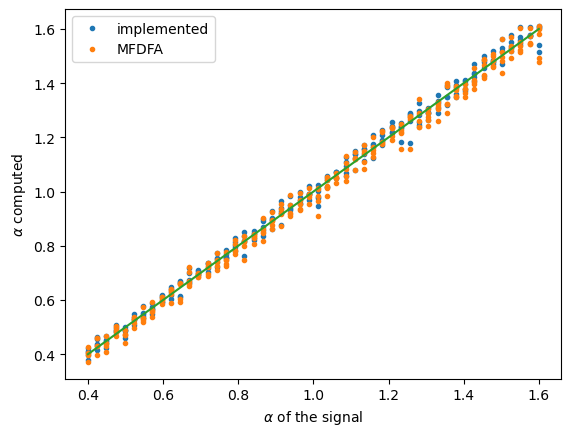

In [12]:
plt.plot(x,y1, '.', label="implemented")
plt.plot(x,y2, '.', label="MFDFA")
plt.plot(alphas, alphas)

plt.xlabel(r"$\alpha$ of the signal")
plt.ylabel(r"$\alpha$ computed")
plt.legend()

plt.show()

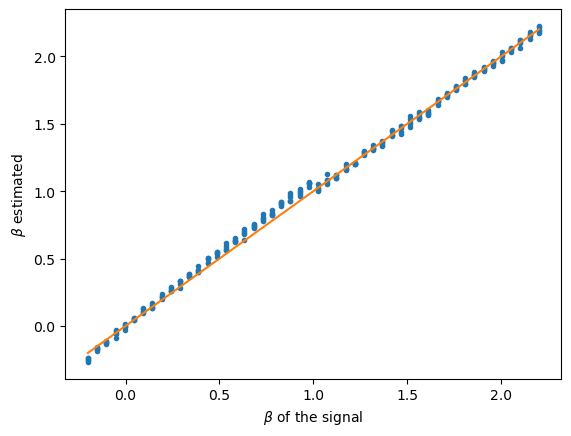

In [13]:
plt.plot(x2, y3, '.')
actual_power = []
for alpha in alphas:
    actual_power.append(2*alpha-1)
    
betas = [2*a - 1 for a in alphas]
plt.plot(betas, actual_power)

plt.xlabel(r"$\beta$ of the signal")
plt.ylabel(r"$\beta$ estimated")
plt.show()

In [14]:
# Taking the mean of the diffences for the same Hurst exponent
acc_diff_v1 = []
tmp_v1 = []
acc_diff_v2 = []
tmp_v2 = []
acc_pow = []
tmp_pow = []
for i in range(num_points*times):
    tmp_v1.append(diff_v1[i])
    tmp_v2.append(diff_v2[i])
    tmp_pow.append(diff_pow[i])
    if (i+1)%times==0:
        acc_diff_v1.append(np.mean(tmp_v1))
        acc_diff_v2.append(np.mean(tmp_v2))
        acc_pow.append(np.mean(tmp_pow))
        tmp_v1 = []
        tmp_v2 = []
        tmp_pow = []
    

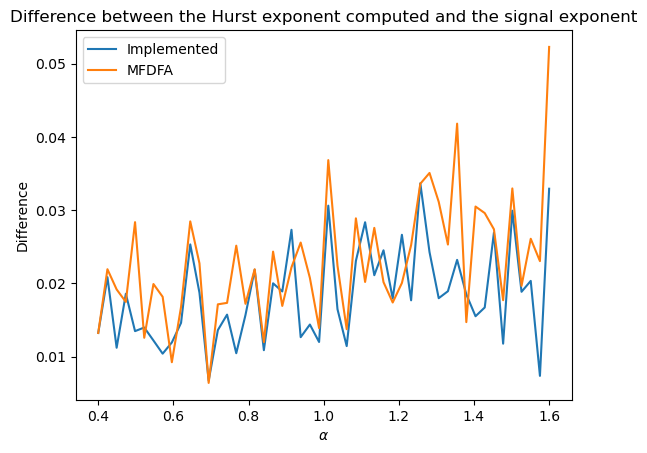

In [15]:
plt.plot(alphas, acc_diff_v1, label="Implemented")
plt.plot(alphas, acc_diff_v2, label="MFDFA")

plt.xlabel(r"$\alpha$")
plt.ylabel("Difference")
plt.title("Difference between the Hurst exponent computed and the signal exponent")
plt.legend()
plt.show()

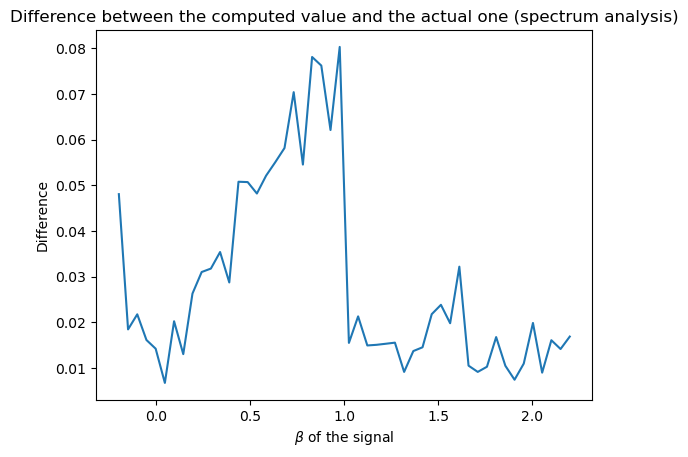

In [16]:
plt.plot(betas, acc_pow)
plt.xlabel(r"$\beta$ of the signal")
plt.ylabel("Difference")
plt.title("Difference between the computed value and the actual one (spectrum analysis)")
plt.show()